In [ ]:
import scipy
import sklearn
#import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import math as m
import pandas as pd
import os
from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error,confusion_matrix,classification_report
import csv
from sklearn.metrics import ConfusionMatrixDisplay
from scipy import signal, ndimage
from scipy.io.wavfile import read
from scipy.signal import periodogram
from scipy.ndimage import median_filter
from matplotlib import pyplot
from numpy import trapz
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.tree import  DecisionTreeClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix,classification_report
from google.colab import drive ## If running on google colab
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.tree import  DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC,LinearSVC
from scipy.signal import butter,filtfilt
from scipy.signal import decimate

In [ ]:
pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=19611671f294d88f6a8becb848b34ba3bb5238e589cdbd0aa62740f4a46783c7
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [ ]:
## Import data from folder
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


PREPROCESSING

In [ ]:
def preprocess_cough(x,fs, cutoff = 6000, normalize = True, filter_ = True, downsample = True):
    """
    Normalize, lowpass filter, and downsample cough samples in a given data folder 
    
    Inputs: x*: (float array) time series cough signal
    fs*: (int) sampling frequency of the cough signal in Hz
    cutoff: (int) cutoff frequency of lowpass filter
    normalize: (bool) normailzation on or off
    filter: (bool) filtering on or off
    downsample: (bool) downsampling on or off
    *: mandatory input
    
    Outputs: x: (float32 array) new preprocessed cough signal
    fs: (int) new sampling frequency
    """
    
    fs_downsample = cutoff*2
    
    #Preprocess Data
    if len(x.shape)>1:
        x = np.mean(x,axis=1)                          # Convert to mono
    if normalize:
        x = x/(np.max(np.abs(x))+1e-17)                # Norm to range between -1 to 1
    if filter_:
        b, a = butter(4, fs_downsample/fs, btype='lowpass') # 4th order butter lowpass filter
        x = filtfilt(b, a, x)
    if downsample:
        x = scipy.signal.decimate(x, int(fs/fs_downsample)) # Downsample for anti-aliasing
    
    fs_new = fs_downsample

    return np.float32(x), fs_new

SEGMENT THE COUGHS

In [ ]:
def segment_cough(x,fs, cough_padding=0.2,min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
    """Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power
    
    Inputs:
    *x (np.array): cough signal
    *fs (float): sampling frequency in Hz
    *cough_padding (float): number of seconds added to the beginning and end of each detected cough to make sure coughs are not cut short
    *min_cough_length (float): length of the minimum possible segment that can be considered a cough
    *th_l_multiplier (float): multiplier of the RMS energy used as a lower threshold of the hysteresis comparator
    *th_h_multiplier (float): multiplier of the RMS energy used as a high threshold of the hysteresis comparator
    
    Outputs:
    *coughSegments (np.array of np.arrays): a list of cough signal arrays corresponding to each cough
    cough_mask (np.array): an array of booleans that are True at the indices where a cough is in progress"""
                
    cough_mask = np.array([False]*len(x))
    

    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask

In [ ]:
ver='/content/drive/MyDrive/Colab Notebooks/ORGANIZE/created_csv/file.csv'
with open(ver, 'rt') as f:
    reader = csv.reader(f)
    verified_data = list(reader)

FEATURE EXTRACTION

In [ ]:
import librosa
folder='/content/drive/MyDrive/Colab Notebooks/ORGANIZE/balanced_data/'
all_features=[0]*78
features=[]
labelVector=[]
feature_filename=[]
COVID=1
HEALTHY=0
s=0

index_name=verified_data[0].index('uuid')
index_status=verified_data[0].index('status')
for filename in os.listdir(folder):
  all_segments=[]
  features=[]
  mfcc_feat=[]
  mfcc_std=[]
  mfcc_mean=[]
  delta_feat=[]
  delta_mean=[]
  delta_std=[]
  delta_delta_feat=[]
  delta_delta_mean=[]
  delta_delta_std=[]
  signal_pre,sr=librosa.load(folder+filename,sr =20000)
  #signal_pre,fs_pre=preprocess_cough(signal,fs=sr, cutoff = 10000, normalize = True, filter_ = False, downsample = False)
  fs_pre=sr
  segment,mask=segment_cough(signal_pre,fs_pre,cough_padding=0.1,min_cough_len=0.1, th_l_multiplier = 0.1, th_h_multiplier = 2)
  if len(segment)>1:
    for line in segment:
      all_segments=np.append(all_segments,line) #all the segments in one row from each file, one segment=one cough 
  elif len(segment)==1:
    all_segments=np.array(segment[0])
  if all_segments==[]:
    print(filename)
    all_segments=signal_pre
  mfcc_feat=mfcc(all_segments,samplerate=fs_pre,winlen=0.025, winstep=0.01, numcep=13, lowfreq=0, highfreq=10000)
  mfcc_mean=mfcc_feat.mean(axis=0)
  mfcc_std=mfcc_feat.std(axis=0)
  delta_feat=delta(mfcc_feat,2)
  delta_mean=delta_feat.mean(axis=0)
  delta_std=delta_feat.std(axis=0)
  delta_delta_feat=delta(delta_feat,2)
  delta_delta_mean=delta_delta_feat.mean(axis=0)
  delta_delta_std=delta_delta_feat.std(axis=0)
  features.append(mfcc_mean)
  features.append(mfcc_std)
  features.append(delta_mean)
  features.append(delta_std)
  features.append(delta_delta_mean)
  features.append(delta_delta_std)
  features_flat_list=[]
  for i in range(6):
    for j in range(13):
      features_flat_list.append(features[i][j])
  all_features=np.vstack((all_features,features_flat_list))
  for i in range(1,len(verified_data)):
    if verified_data[i][index_name]==filename[:36]:
      if verified_data[i][index_status]=='COVID-19':
        labelVector.append(COVID)
      elif verified_data[i][index_status]=='healthy':
        labelVector.append(HEALTHY)
  feature_filename.append(filename)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


b3e0dc79-0457-4a79-83ce-810e36215ffd.wav
e73d5a4e-b7cc-416b-8103-8aabacf3b8fe.wav
33b688eb-cae8-40cb-9d71-694f5d2f417f.wav
35618eb7-d045-42b0-8207-e6b80b58e920.wav
3eb220d3-3d77-4af3-a525-062776fdd43f.wav
6ac1cde9-7727-49d2-848c-983e2e541845.wav
c2356246-454a-42ac-ae33-967e5feabcb7.wav
f6205ed8-a1cc-4685-aadc-c5bf8cc87490.wav
4c9ce6f7-8ca8-41b9-8e18-8cd3de335c48.wav
4cfe71ea-00f2-4595-9903-85dd74968690.wav
5aa37322-c3d3-4a00-990e-4a5ce265fbfe.wav
8c6b92b4-6cdc-4a92-84e9-dc32f24ca87e.wav
e8a4c9ee-66e8-473c-9f1b-40918a92a928.wav


In [ ]:
print(len(labelVector))
print(feature_filename)
all_features=all_features[1:][:]
print(len(all_features))

1390
['f028405b-2f4f-4379-ba3e-acc7a69f90be.wav', 'f0587ead-efbf-41c1-beb3-faefe195629b.wav', 'efbcf50f-5ffa-4cdb-b146-fa7e974aaa1e.wav', 'f0da0dd1-a4d1-47ac-bc31-e9c6ceb05e28.wav', 'f06dc4f4-26ec-4743-940c-505fb4dea0cb.wav', 'f1b271ee-6902-4cff-b260-cfdf9bc3fa1f.wav', 'f42f1d8b-0ed8-4ed3-bb32-637f8c52ce5d.wav', 'f6ffd0b9-8708-4a79-ba7c-1557df8ac814.wav', 'f504d41c-13e5-4d7a-9a91-0436aab969cf.wav', 'f67d8450-f76e-4c47-bbbe-85418e320acb.wav', 'f76b3127-9c87-42ad-a745-6db235e9d632.wav', 'f74c0bc5-65ab-417c-b039-563afca97836.wav', 'f87d25cd-c9b0-409c-be18-39a7f80f2ff0.wav', 'f8053fc3-bc4e-403b-b9d4-14133cfe83a6.wav', 'f7a10fb3-b805-4ed0-8a93-9b0851efe78e.wav', 'f930602c-d0c5-4f91-ba64-9f86dff15d78.wav', 'f89ce6e7-5b0d-491f-8a69-c1c8c98166be.wav', 'f942b766-ef1e-42e7-826d-40e053414824.wav', 'f9f812f9-f076-4f39-9cd7-b2a18a5da82f.wav', 'f9c4e39b-ad65-47a2-98bd-af70af6749a8.wav', 'fc09bf22-b83e-4f75-9db0-0d1180019ac2.wav', 'fb3e67fd-8b81-49f0-b6fb-178903f2c79a.wav', 'fd0859a7-9b11-405f-b151-6

SCALING THE FEATURES

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(all_features)
scalerAndFit=scaler.transform(all_features)

TRAINING SVM

In [ ]:
#Grid search SVC
X=scalerAndFit
y=labelVector
model = SVC(cache_size=2000)
gamma_range = np.logspace(-10,10,5,base=2)
C_range = np.logspace(-10,10,5,base=2)
param_grid = dict(gamma=gamma_range, C = C_range, kernel=['rbf'],tol=[0.001])
#param_grid = dict(gamma=[0.00909765625], C = [32], kernel=['rbf'],tol=[0.001])
#model = SVC(C=32,gamma=0.00909765625,kernel='rbf',tol=0.001)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best: 0.531655 using {'C': 1.0, 'gamma': 0.03125, 'kernel': 'rbf', 'tol': 0.001}
0.496403 (0.000000) with: {'C': 0.0009765625, 'gamma': 0.0009765625, 'kernel': 'rbf', 'tol': 0.001}
0.496403 (0.000000) with: {'C': 0.0009765625, 'gamma': 0.03125, 'kernel': 'rbf', 'tol': 0.001}
0.496403 (0.000000) with: {'C': 0.0009765625, 'gamma': 1.0, 'kernel': 'rbf', 'tol': 0.001}
0.496403 (0.000000) with: {'C': 0.0009765625, 'gamma': 32.0, 'kernel': 'rbf', 'tol': 0.001}
0.496403 (0.000000) with: {'C': 0.0009765625, 'gamma': 1024.0, 'kernel': 'rbf', 'tol': 0.001}
0.496403 (0.000000) with: {'C': 0.03125, 'gamma': 0.0009765625, 'kernel': 'rbf', 'tol': 0.001}
0.496403 (0.000000) with: {'C': 0.03125, 'gamma': 0.03125, 'kernel': 'rbf', 'tol': 0.001}
0.496403 (0.000000) with: {'C': 0.03125, 'gamma': 1.0, 'kernel': 'rbf', 'tol': 0.001}
0.496403 (0.000000) with: {'C': 0.03125, 'gamma': 32.0, 'kernel': 'rbf', 'tol': 0.001}
0.496403 (0.000000) with: 

In [ ]:
grid_result.best_params_

{'C': 1.0, 'gamma': 0.03125, 'kernel': 'rbf', 'tol': 0.001}

In [ ]:
conf_matrix_list_of_arrays = [] #1390
X_test=np.zeros((139,78))
X_train=np.zeros((1251,78))
Y_test=[0]*139
Y_train=[0]*1251
for i in range(0,10):
  X_test[:][:]=X[i*139:139*(i+1)][:]
  Y_test[:]=y[i*139:139*(i+1)]
  if i==0:
    X_train[:][:]=X[139:][:]
    Y_train[:]=y[139:]
  elif i>0 or i<9:
    X_train=np.vstack((X[0:139*(i)][:],X[139*(i+1):][:]))
    Y_train[:]=np.append(y[0:139*(i)],y[139*(i+1):])
  else:
    X_train[:][:]=X[139*i][:]
    Y_train[:][:]=y[139*i][:]
  clf_svm = SVC(**grid_result.best_params_)
  clf_svm.fit(X_train,Y_train)
  conf_matrix = confusion_matrix(Y_test, clf_svm.predict(X_test))
  conf_matrix_list_of_arrays.append(conf_matrix)

In [ ]:
#from sklearn.model_selection import KFold
#kf = KFold(n_splits=10)
#conf_matrix_list_of_arrays=[]
#folds = StratifiedKFold(n_splits=10)
#y=np.array(y)
#for train_index, test_index in folds.split(X,y):
#  X_train=X[train_index]
#  X_test=X[test_index]
#  y_train=y[train_index]
#  y_test=y[test_index]
#  clf_svm = SVC(**grid_result.best_params_)
#  clf_svm.fit(X_train,y_train)
#  conf_matrix = confusion_matrix(y_test, clf_svm.predict(X_test))
#  conf_matrix_list_of_arrays.append(conf_matrix) 

In [ ]:
print(conf_matrix_list_of_arrays)

[array([[29, 18],
       [52, 40]]), array([[35, 28],
       [33, 43]]), array([[33, 40],
       [24, 42]]), array([[33, 38],
       [28, 40]]), array([[36, 41],
       [22, 40]]), array([[30, 47],
       [22, 40]]), array([[39, 37],
       [31, 32]]), array([[40, 32],
       [33, 34]]), array([[33, 38],
       [30, 38]]), array([[35, 33],
       [27, 44]])]


              precision    recall  f1-score   support

     healthy       0.53      0.49      0.51       695
    COVID-19       0.53      0.57      0.55       695

    accuracy                           0.53      1390
   macro avg       0.53      0.53      0.53      1390
weighted avg       0.53      0.53      0.53      1390



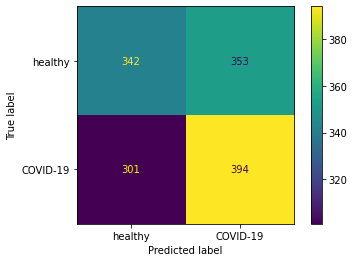

In [ ]:
display_labels=['healthy','COVID-19']
y_pred_svm = cross_val_predict(clf_svm ,X,y,cv=10)
print(classification_report(y,y_pred_svm,target_names=display_labels))
cm_svm = confusion_matrix(y,y_pred_svm)
ConfusionMatrixDisplay(cm_svm,display_labels=display_labels).plot(values_format='.0f')

>10 0.512 (0.037)
>20 0.524 (0.048)
>30 0.518 (0.031)
>40 0.527 (0.031)
>50 0.531 (0.039)


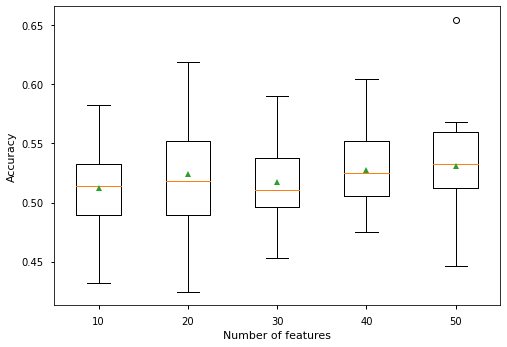

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
# get a list of models to evaluate 
def get_models():
  models = dict()
  for i in range(10, 60,10):
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
    model = SVC(**grid_result.best_params_)
    models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
  return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
#X, y = x_scaled,np.argmax(one_hot_y,axis=1)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.style.use('seaborn-notebook')
plt.boxplot(results, labels=names, showmeans=True)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.show()

XGBoost

In [ ]:
from xgboost import XGBClassifier
# grid search
model = XGBClassifier()
n_estimators = [200,600,800,1000]
max_depth = [2, 4, 6,8]
learning_rate = [0.01]
gamma = [0]
reg_lambda = [1]
alpha = [0]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators,learning_rate=learning_rate,gamma=gamma,reg_lambda=reg_lambda,alpha=alpha)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

[2, 4, 6, 8]
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best: 0.544603 using {'alpha': 0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 1}
0.544211 (0.029271) with: {'alpha': 0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200, 'reg_lambda': 1}
0.532353 (0.031414) with: {'alpha': 0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 600, 'reg_lambda': 1}
0.535608 (0.034003) with: {'alpha': 0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 800, 'reg_lambda': 1}
0.535294 (0.036987) with: {'alpha': 0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1000, 'reg_lambda': 1}
0.544603 (0.038537) with: {'alpha': 0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 1}
0.521363 (0.036224) with: {'alpha': 0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 600, 'reg_lambda': 1}
0.512514 (0.047435) with: {'alph

In [ ]:
conf_matrix_list_of_arrays = [] #1450
X_test=np.zeros((139,78))
X_train=np.zeros((1251,78))
Y_test=[0]*139
Y_train=[0]*1251
for i in range(0,10):
  X_test[:][:]=X[i*139:139*(i+1)][:]
  Y_test[:]=y[i*139:139*(i+1)]
  if i==0:
    X_train[:][:]=X[139:][:]
    Y_train[:]=y[139:]
  elif i>0 or i<9:
    X_train=np.vstack((X[0:139*(i)][:],X[139*(i+1):][:]))
    Y_train[:]=np.append(y[0:139*(i)],y[139*(i+1):])
  else:
    X_train[:][:]=X[139*i][:]
    Y_train[:][:]=y[139*i][:]
  clf_xgb = XGBClassifier(**grid_result.best_params_)
  clf_xgb.fit(X_train,Y_train)
  conf_matrix = confusion_matrix(Y_test, clf_xgb.predict(X_test))
  conf_matrix_list_of_arrays.append(conf_matrix)

In [ ]:
#from sklearn.model_selection import KFold
#kf = KFold(n_splits=10)
#folds = StratifiedKFold(n_splits=10)
#y=np.array(y)
#labelVector=np.array(labelVector)
#for train_index, test_index in folds.split(scalerAndFit,labelVector):
#  X_train=scalerAndFit[train_index]
#  X_test=scalerAndFit[test_index]
#  y_train=labelVector[train_index]
#  y_test=labelVector[test_index]
#  clf_svm = SVC(**grid_result.best_params_)
#  clf_svm.fit(X_train,y_train)
#  conf_matrix = confusion_matrix(y_test, clf_svm.predict(X_test))
#  conf_matrix_list_of_arrays.append(conf_matrix) 

In [ ]:
y_pred_xgb = cross_val_predict(clf_xgb,X,y,cv=5)

              precision    recall  f1-score   support

     healthy       0.52      0.49      0.51       695
    COVID-19       0.52      0.54      0.53       695

    accuracy                           0.52      1390
   macro avg       0.52      0.52      0.52      1390
weighted avg       0.52      0.52      0.52      1390



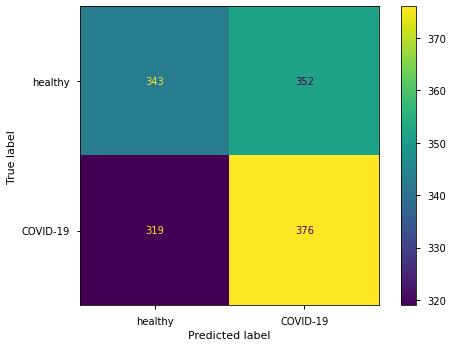

In [ ]:
display_labels=['healthy','COVID-19']
print(classification_report(y,y_pred_xgb,target_names=display_labels))
cm_xgb = confusion_matrix(y,y_pred_xgb)
ConfusionMatrixDisplay(cm_xgb,display_labels=display_labels).plot(values_format='.0f')

>10 0.501 (0.037)
>20 0.521 (0.043)
>30 0.508 (0.040)
>40 0.502 (0.047)


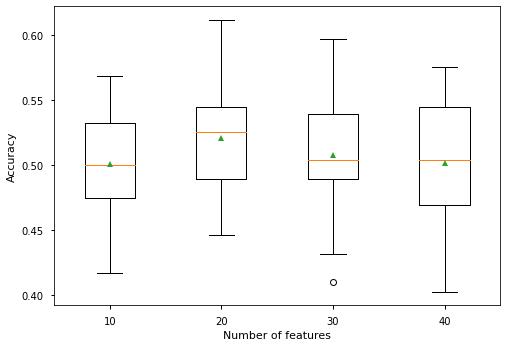

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
# get a list of models to evaluate 
def get_models():
  models = dict()
  for i in range(10, 50,10):
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
    model = XGBClassifier(**grid_result.best_params_)
    models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
  return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
#X, y = x_scaled,np.argmax(one_hot_y,axis=1)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.style.use('seaborn-notebook')
plt.boxplot(results, labels=names, showmeans=True)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.show()

FULLY CONNECTED ANN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Conv2D, MaxPooling1D,MaxPool2D,Dropout,Activation, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from keras.models import Sequential
def create_model(optimizer='adam',n_neurons=32,dropout_rates=0.5):
  base_model = Sequential()
  base_model.add(Dense(n_neurons, activation='relu', input_shape=(78,))) #inputlayer and dense
  base_model.add(Dropout(dropout_rates)) #dropout_1
  base_model.add(Dense(n_neurons, activation='relu')) #dense_2
  base_model.add(Dropout(dropout_rates)) #dropout_2
  base_model.add(Dense(1, activation='sigmoid')) #output=dense
  base_model._name = "ANN_model"
  base_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
  return base_model

In [ ]:
keras_clf = KerasClassifier(build_fn=create_model, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from joblib import Parallel, delayed
import dill as pickle
from joblibspark import register_spark
import os
os.environ["DATABRICKS_HOST"] = "<YOUR DATABRICKS HOST>"
os.environ["DATABRICKS_TOKEN"] = "<YOUR DATABRICKS TOKEN>"
register_spark()
Parallel(n_jobs=-1, backend="spark")
batch_size=[32,64,128]
epochs=[10,50,100]
optimizer=['SGD','Adam']
neurons=[32,64]
dropout_rates=[0,0.5]
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

param_grid=dict(optimizer=optimizer,batch_size=batch_size,epochs=epochs,n_neurons=neurons,dropout_rates=dropout_rates)
grid=GridSearchCV(estimator=keras_clf,param_grid=param_grid, scoring='accuracy',cv=5, verbose=1)
#grid = GridSearchCV(estimator=base_model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result=grid.fit(X,y)
#grid_search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=1)
#grid_result = grid_search.fit(X,y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best: 0.545324 using {'batch_size': 128, 'dropout_rates': 0, 'epochs': 50, 'n_neurons': 32, 'optimizer': 'SGD'}
0.509353 (0.022590) with: {'batch_size': 32, 'dropout_rates': 0, 'epochs': 10, 'n_neurons': 32, 'optimizer': 'SGD'}
0.525899 (0.030387) with: {'batch_size': 32, 'dropout_rates': 0, 'epochs': 10, 'n_neurons': 32, 'optimizer': 'Adam'}
0.509353 (0.020801) with: {'batch_size': 32, 'dropout_rates': 0, 'epochs': 10, 'n_neurons': 64, 'optimizer': 'SGD'}
0.512230 (0.017415) with: {'batch_size': 32, 'dropout_rates': 0, 'epochs': 10, 'n_neurons': 64, 'optimizer': 'Adam'}
0.529496 (0.029347) with: {'batch_size': 32, 'dropout_rates': 0, 'epochs': 50, 'n_neurons': 32, 'optimizer': 'SGD'}
0.523022 (0.014496) with: {'batch_size': 32, 'dropout_rates': 0, 'epochs': 50, 'n_neurons': 32, 'optimizer': 'Adam'}
0.534532 (0.035362) with: {'batch_size': 32, 'dropout_rates': 0, 'epochs': 50, 'n_neurons': 64, 'optimizer': 'SGD'}
0.541007 (0

In [ ]:
pip install joblibspark

In [ ]:
import tensorflow as tf
#best result: {'batch_size': 128, 'dropout_rates': 0, 'epochs': 100, 'n_neurons': 32, 'optimizer': 'SGD'}
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=25)
conf_matrix_list_of_arrays = []
X_test=np.zeros((139,78))
X_train=np.zeros((1251,78))
Y_test=[0]*139
Y_train=[0]*1251
for i in range(0,10):
  X_test[:][:]=X[i*139:139*(i+1)][:]
  Y_test[:]=y[i*139:139*(i+1)]
  if i==0:
    X_train[:][:]=X[139:][:]
    Y_train[:]=y[139:]
    #print(X_train.shape)
  elif i>0 or i<9:
    X_train=np.vstack((X[0:139*(i)][:],X[139*(i+1):][:]))
    #Y_train=np.vstack((y[0:145*(i)],y[126*(i+1):]))
    Y_train[:]=np.append(y[0:139*(i)],y[139*(i+1):])
    #print(X_train.shape)
  else:
    X_train[:][:]=X[139*i][:]
    Y_train[:][:]=y[139*i][:]
  base_model = Sequential()
  n_neurons=32
  dropout_rates=0
  #best result: {'batch_size': 64, 'dropout_rates': 0, 'epochs': 100, 'n_neurons': 32, 'optimizer': 'SGD'}
  base_model.add(Dense(n_neurons, activation='relu', input_shape=(78,))) #inputlayer and dense
  base_model.add(Dropout(dropout_rates)) #dropout_1
  base_model.add(Dense(n_neurons, activation='relu')) #dense_2
  base_model.add(Dropout(dropout_rates)) #dropout_2
  base_model.add(Dense(1, activation='sigmoid')) #output=dense
  base_model._name = "ANN_model"
  base_model.compile(optimizer='SGD',loss='binary_crossentropy',metrics=['accuracy'])
  #ANN = base_model(optimizer='adam',n_neurons=32,dropout_rates=0)
  X_train=np.array(X_train)
  Y_train=np.array(Y_train)
  X_val=np.array(X_test)
  Y_val=np.array(Y_test)
  historyyy=base_model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=64,epochs=100)
  #ANN.fit(X_train,Y_train)
  Y_predict=base_model.predict(X_test)
  Y_predict = (Y_predict > 0.5)
  #print(Y_predict)
  conf_matrix = confusion_matrix(Y_test, Y_predict)
  conf_matrix_list_of_arrays.append(conf_matrix)

Epoch 1/100
20/20 [==============================] - 1s 11ms/step - loss: 0.7623 - accuracy: 0.5108 - val_loss: 0.6742 - val_accuracy: 0.5683
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 0.7283 - accuracy: 0.5220 - val_loss: 0.6972 - val_accuracy: 0.5755
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7153 - accuracy: 0.5324 - val_loss: 0.7053 - val_accuracy: 0.5612
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 0.7086 - accuracy: 0.5380 - val_loss: 0.7113 - val_accuracy: 0.5324
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 0.7037 - accuracy: 0.5460 - val_loss: 0.7096 - val_accuracy: 0.5324
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7001 - accuracy: 0.5540 - val_loss: 0.7159 - val_accuracy: 0.5180
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6969 - accuracy: 0.5564 - val_loss: 0.7154 - val_accuracy: 0.5036
Epoch 8/100


              precision    recall  f1-score   support

           0       0.51      0.56      0.53       695
           1       0.51      0.45      0.48       695

    accuracy                           0.51      1390
   macro avg       0.51      0.51      0.51      1390
weighted avg       0.51      0.51      0.51      1390



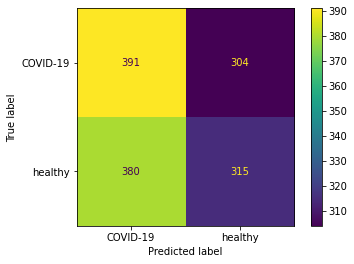

In [ ]:
display_labels=['COVID-19','healthy']
y_pred_ANN=cross_val_predict(estimator=keras_clf,X=X,y=y,cv=5)
cm_ANN = confusion_matrix(y,y_pred_ANN)
print(classification_report(y,y_pred_ANN))
ConfusionMatrixDisplay(cm_ANN,display_labels=display_labels).plot(values_format='.0f')

In [ ]:
base_model.save('mymodal_f2.h5')

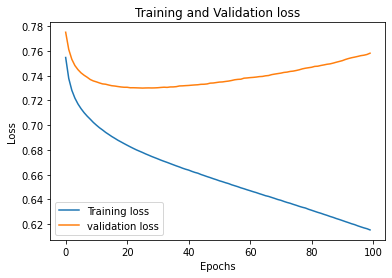

In [ ]:
plt.plot(historyyy.history['loss'],label='Training loss')
plt.plot(historyyy.history['val_loss'],label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()